### Домашнее задание

- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


In [ ]:
!pip install shap
!pip install catboost

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tqdm.auto import tqdm
from xgboost import XGBClassifier, XGBModel
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay, roc_auc_score, \
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, classification_report, recall_score, accuracy_score, \
        r2_score

tqdm.pandas()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set_style("darkgrid", {"grid.color": ".8", "grid.linestyle": ":"})

## Вспомогательные функции и классы

In [ ]:

def df_overview(df, ascateg=[], cols=2, size=(12, 12)):
    """ Функция выводит обзорные графики колонок датасета в виде сетки с кол-вом колонок cols """
  
    n = len(df.columns)
    
    if n % cols == 0:
        rows = n // cols
    else:
        rows = n // cols + 1
    
    fig, axs = plt.subplots(rows, cols, figsize=size)
   
    # скроем все сетки
    for ax in axs.ravel():
        ax.axison = False
        
    for feat, ax in tqdm(zip(df.columns, axs.ravel())):
      
        ax.axison = True
        if df[feat].dtype == 'object' or feat in ascateg:
            sns.countplot(data=df, x=feat, ax=ax)
        else:
            sns.histplot(data=df, x=feat, kde=True, ax=ax)
        ax.set_xlabel(feat, fontsize=10)
        ax.set_ylabel("Count", fontsize=9)
        ax.tick_params(labelsize=6)

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def get_feature_names_out(self, feature_names_out):
        if feature_names_out:
            return feature_names_out
        else:
            return [self.key]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def get_feature_names_out(self, feature_names_out):
        return self.columns
        
    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key, dtype=np.int8)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [ ]:
def metric_calculation(y_test: np.ndarray, y_predict: np.ndarray, y_pred_proba: np.ndarray) -> dict:
    print(f'Metrics:')
    
    acc = accuracy_score(y_test, y_predict)
    print(f"Accuracy: {acc}") 
    
    f1 = f1_score(y_test, y_predict)
    print(f"F1: {f1}") 
    
    roc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC: {roc}") 
    
    rec = recall_score(y_test, y_predict)
    print(f"Recall: {rec}") 
    
    prc = precision_score(y_test, y_predict)
    print(f"Precision: {prc}") 
    
    cm = confusion_matrix(y_test, y_predict)
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion matrix: TN={tn} FP={fp} FN={fn} TP={tp}")
    
    return {"accuracy": acc, "f1 score": f1, "roc-auc score": roc, "recal score": rec, "precision score": prc, "conf_matrix": cm}

In [ ]:
def plot_precision_recall_curve(y_true, y_pred_score, beta=1):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_score)
    fscore = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    
    if np.isnan(fscore).any():
        fscore = np.nan_to_num(fscore, nan=0.0)
    ix = np.argmax(fscore)
        
    print(f"Best Threshold={thresholds[ix]}", 
        f"F-Score={fscore[ix]:.03f}",
        f"Beta={beta}", 
        f"Precision={precision[ix]:.03f}", 
        f"Recall={recall[ix]:.03f}")

    plt.figure(figsize=(9, 6))
    PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=plt.gca())
    
    plt.axvline(recall[ix], color="red", alpha=1, ls="--", 
                label=f"Recall={recall[ix]:.03f}")
    
    plt.axhline(precision[ix], color="red", alpha=1, ls="-.",
                label=f"Precision={precision[ix]:.03f}")
    plt.title(f"Precision-recall кривая (Max F-score: {fscore[ix]:.03f} beta={beta})")
    plt.legend()
    plt.grid()
    # plt.tight_layout()
    plt.show()
    return precision, recall, thresholds, fscore, ix

def plot_roc_auc_curve(y_true, y_pred_score):
    score = roc_auc_score(y_true, y_pred_score)
    print(f"ROC-AUC score: {score:.03f}")
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_score)
    plt.figure(figsize=(9, 6))
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=plt.gca())
    plt.title(f"ROC-AUC кривая (Score: {score:.03f})")
    plt.grid()
    # plt.tight_layout()
    plt.show()
    return score
    
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion matrix: TN={tn} FP={fp} FN={fn} TP={tp}")
    
    plt.figure(figsize=(9, 6))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(ax=plt.gca(), cmap='cividis')
    plt.title("Матрица ошибок")
    plt.grid()
    # plt.tight_layout()
    plt.show()
    return cm

## Описание датасета

Для выполнения задания выбран датасет для бинарной классификации: https://www.kaggle.com/datasets/alexteboul/heart-disease-health-indicators-dataset

Этот набор данных содержит 253680 ответов на опрос из очищенного BRFSS 2015.

BRFSS - Система наблюдения за поведенческими факторами риска, которая представляет собой телефонный опрос, связанный со здоровьем, ежегодно собираемый CDC. Ежегодно (с 1984 года), в рамках опроса, собираются ответы более 400 000 американцев о рискованном для здоровья поведении, хронических заболеваниях и использовании профилактических услуг.

Датасет содержит:

* одну бинарную целевую переменную: HeartDiseaseorAttack 
* 21 функциональную переменную


## Загрузка данных

In [ ]:
DF = pd.read_csv("drive/MyDrive/heart_disease_health_indicators_BRFSS2015.csv", delimiter=",")
DF

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,0.0,1.0,1.0,1.0,18.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


## EDA

### Обзор датасета

In [ ]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [ ]:
DF.describe()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.094186,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.296921,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.292087,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.698160,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


0it [00:00, ?it/s]

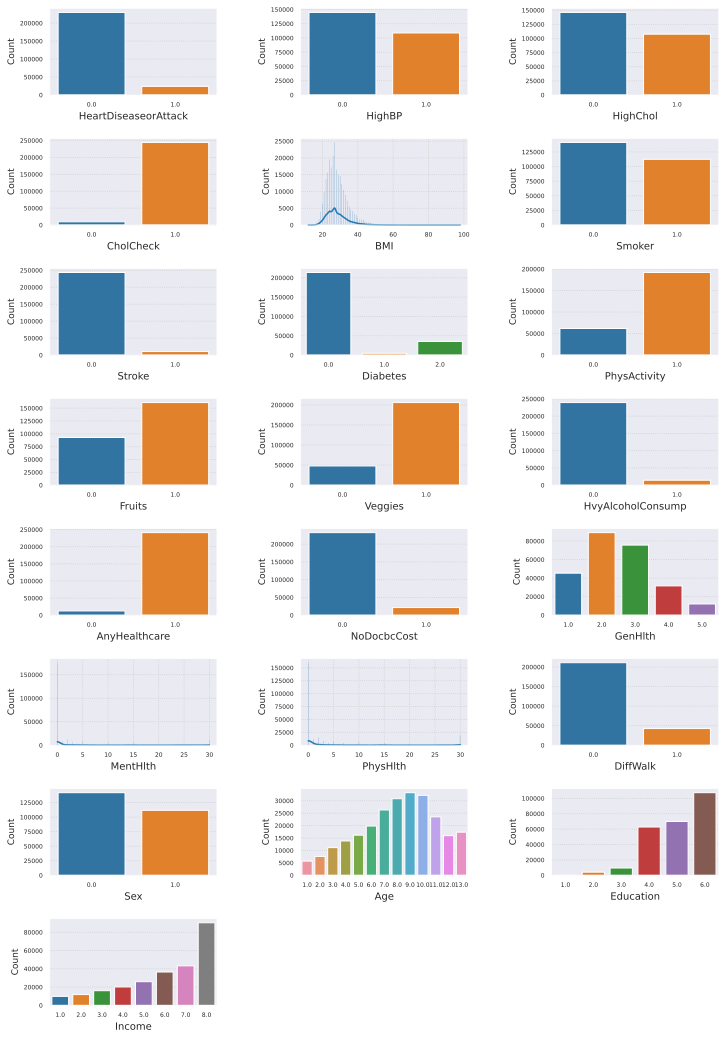

In [ ]:
show_as_categ = ['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'Diabetes', 
                 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 
                 'DiffWalk', 'Sex', 'Age', 'Education', 'Income'] 
df_overview(DF, ascateg=show_as_categ, cols=3, size=(12, 18))

Замечания на основании обзора датасета: 

* данные подготовлен, очищены и приведены к нужному типу

* возраст пациентов в датасете разбит на 14 групп. Поле Age - это группа возраста.

* сильный дисбаланс классов у целевой переменной (HeartDiseaseorAttack).

* разреженность многих признаков (CholCheck, Stroke, AnyHealthCare, MentHlth, PhysHlth, ...)

### Проверим корреляцию признаков

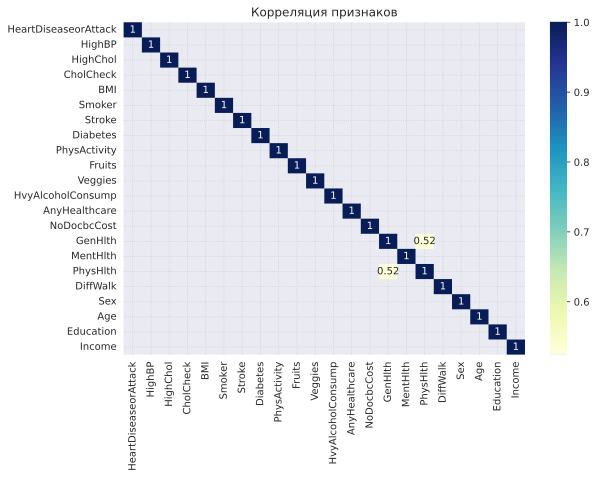

In [ ]:
corr = DF.corr()
filt_corr = corr[np.abs(corr) >= 0.5]

plt.figure(figsize=(9, 6))
sns.heatmap(filt_corr, cmap="YlGnBu", annot=True)
plt.title("Корреляция признаков")
plt.show()

Есть линейно-зависимые признаки: PhysHlth-GenHlth

## Разделение датасета на тренировочную и валидационную часть

In [ ]:
FEATS = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 
         'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Education', 'Income', 'Age', 'MentHlth', 'BMI'] # 'PhysHlth',
TARGET = 'HeartDiseaseorAttack'

X_train, X_test, y_train, y_test = train_test_split(DF[FEATS], DF[TARGET], test_size=0.3, stratify=DF[TARGET], random_state=42)

## Пайп-лайн

In [ ]:
for c in show_as_categ: 
     if c not in ['Age','HeartDiseaseorAttack']:
         DF[c] = DF[c].astype('str')

In [ ]:
categ_feats = []
bin_feats = [] 
scaler_feats = FEATS  

Опробуем разные классификаторы

In [ ]:

classifier = 'XGBClassifier' 

In [ ]:
TRANSFORMERS = []

for col in bin_feats:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col))])))

for col in scaler_feats:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col)), ('scaler', StandardScaler())])))

for col in categ_feats:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col)), ('ohe', OHEEncoder(key=col))])))

vc = y_train.value_counts()
scale_pos_weight = int(vc[0] / vc[1])

print(f"Соотношение классов '0' и '1': {scale_pos_weight}")

clf_params = {
    'CatBoostClassifier': {
        'loss_function': 'Logloss',
        'auto_class_weights': 'Balanced',
        'depth': 6,
        'iterations': 300,
        'learning_rate': 0.01,
        'eval_metric': 'AUC',
        'verbose': 200
    },
    'XGBClassifier': {
        'verbosity': 1,
        'max_depth': 5,
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'subsample': 0.5,
        'sampling_method': 'uniform', # 'gradient_based', 'uniform'
        'scale_pos_weight': scale_pos_weight 
    },
    'RandomForestClassifier': {
        'n_jobs': -1,
        'n_estimators': 100,
        'criterion': 'gini',
        'max_depth': 5,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'bootstrap': True
    },
    'BaggingClassifier': {
        'n_jobs': -1,
        'n_estimators': 10,
        'verbose': 1
    },
    'DecisionTreeClassifier': {
        'criterion': 'gini',
        'max_depth': 7,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'class_weight': 'balanced',
          
    },
    'LogisticRegression': {
        'max_iter': 1000,
        'class_weight': 'balanced', # {0:1, 1:10}
        'fit_intercept': True, 
        'penalty': 'l2'
    }
}

PIPELINE = Pipeline([('features', FeatureUnion(TRANSFORMERS))])
# опробуем метод сокращения кол-ва фичей
# PIPELINE.steps.append(('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))))

# выбор нужного классификатора
if classifier == 'CatBoostClassifier':
    PIPELINE.steps.append(('clf', CatBoostClassifier(random_state=42, **clf_params['CatBoostClassifier'])))
elif classifier == 'XGBClassifier':
    PIPELINE.steps.append(('clf', XGBClassifier(random_state=42, **clf_params['XGBClassifier'])))
elif classifier == 'RandomForestClassifier':
    PIPELINE.steps.append(('clf', RandomForestClassifier(random_state=42, **clf_params['RandomForestClassifier'])))
elif classifier == 'BaggingClassifier':
    PIPELINE.steps.append(('clf', BalancedBaggingClassifier(random_state=42, **clf_params['BaggingClassifier'])))
elif classifier == 'DecisionTreeClassifier':
    PIPELINE.steps.append(('clf', DecisionTreeClassifier(random_state=42, **clf_params['DecisionTreeClassifier'])))
else:
    PIPELINE.steps.append(('clf', LogisticRegression(random_state=42, **clf_params['LogisticRegression'])))

PIPELINE.verbose = True


# тренировка 
PIPELINE.fit(X_train, y_train)


Соотношение классов '0' и '1': 9
[Pipeline] .......... (step 1 of 2) Processing features, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  22.4s


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('HighBP',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='HighBP')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('HighChol',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='HighChol')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('CholCheck',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='CholCheck')),
                                                                 ('scaler',
                                                                  St...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))],
         verbose=True)

## Метрики

In [ ]:
# получим вероятности принадлежности к классу '1'
y_test_pred_proba = PIPELINE.predict_proba(X_test)[:, 1]

Т.к. датасет создан для предсказания сердечно-сосудистых заболеваний, то лучше максимизировать recall, т.е. меньше пропускать действительно больных.
Поэтому, "сдвинем" параметр beta метрики f-score. 
 

Best Threshold=0.5808323621749878 F-Score=0.474 Beta=1.5 Precision=0.274 Recall=0.704


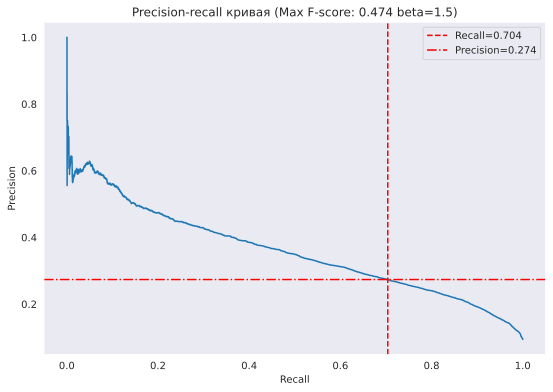

In [ ]:
beta = 1.5
precision, recall, thresholds, fscore, ix = plot_precision_recall_curve(y_test, y_test_pred_proba, beta)

In [ ]:
# y_test_pred = PIPELINE.predict(X_test)
y_test_pred = y_test_pred_proba > thresholds[ix]

In [ ]:
metrics = metric_calculation(y_test, y_test_pred, y_test_pred_proba)

Metrics:
Accuracy: 0.7961473772732051
F1: 0.3940790501484143
ROC-AUC: 0.8420968436837507
Recall: 0.7038225446428571
Precision: 0.2736493816446084
Confusion matrix: TN=55545 FP=13391 FN=2123 TP=5045


ROC-AUC score: 0.842


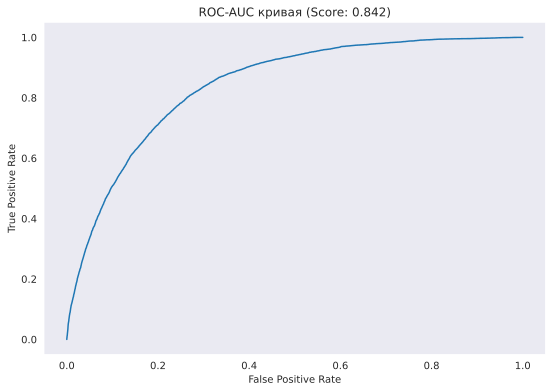

In [ ]:
auc = plot_roc_auc_curve(y_test, y_test_pred_proba)

## Важность признаков

In [ ]:
feature_names = list(PIPELINE.named_steps['features'].get_feature_names_out())

# if PIPELINE.named_steps['clf'].__class__.__name__ == 'LogisticRegression':
if hasattr(PIPELINE.named_steps['clf'], 'feature_importances_'):
    feature_coeff = PIPELINE.named_steps['clf'].feature_importances_
else:
    feature_coeff = PIPELINE.named_steps['clf'].coef_[0]

feature_importance = pd.DataFrame({'feature_name': feature_names, 
                                   'feature_score': feature_coeff
                                   }).sort_values('feature_score', ascending=False).reset_index(drop=True)
feature_importance

,feature_name,feature_score
0,HighBP__HighBP,0.305134
1,GenHlth__GenHlth,0.125164
2,Stroke__Stroke,0.074416
3,HighChol__HighChol,0.074112
4,Age__Age,0.073333
5,Sex__Sex,0.068249
6,DiffWalk__DiffWalk,0.053877
7,Smoker__Smoker,0.036312
8,Diabetes__Diabetes,0.025929
9,Income__Income,0.017531


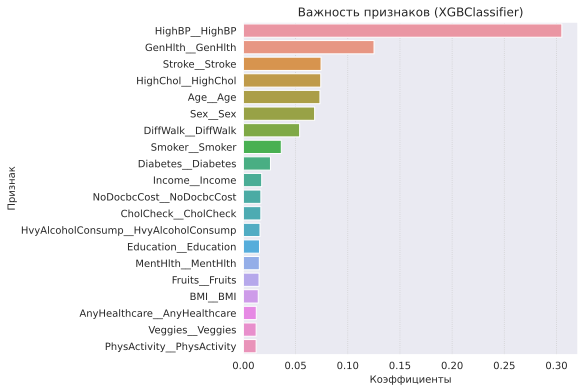

In [ ]:
plt.figure(figsize=(6, 6))
sns.barplot(data=feature_importance, y='feature_name', x='feature_score')
plt.ylabel("Признак")
plt.xlabel("Коэффициенты")
plt.title(f"Важность признаков ({PIPELINE.named_steps['clf'].__class__.__name__})")
plt.show()

### Shap

In [ ]:
if PIPELINE.named_steps['clf'].__class__.__name__ == 'LogisticRegression':
    explainer = shap.LinearExplainer(PIPELINE.named_steps['clf'], X_test)
else:
    explainer = shap.TreeExplainer(PIPELINE.named_steps['clf'], X_test)


sh_values = explainer.shap_values(X_test)

100%|===================| 76051/76104 [01:41<00:00]       

### Summary plot. All features

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


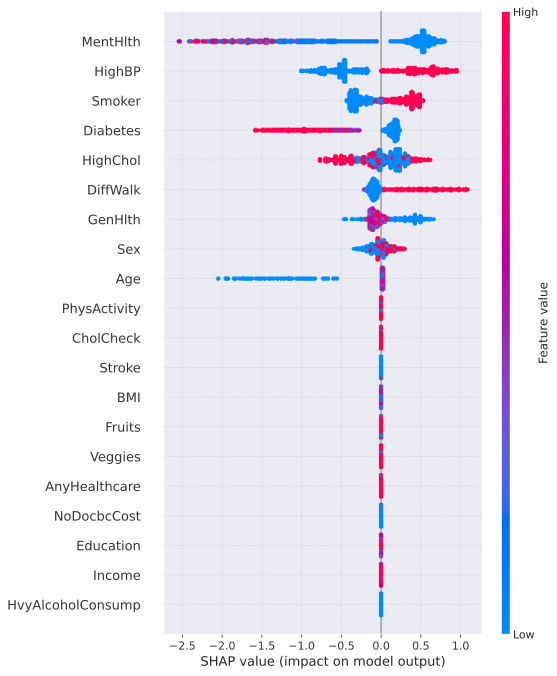

In [ ]:
shap.initjs()
shap.summary_plot(sh_values, X_test)

### Summary plot. Top 10 features

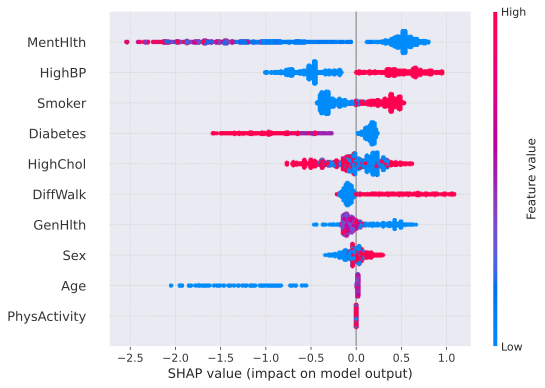

In [ ]:
shap.initjs()
shap.summary_plot(sh_values, X_test, max_display=10)

### Одиночные наблюдения

In [ ]:
shap.initjs()

# id строки данных
pos = 4444

shap.force_plot(explainer.expected_value, sh_values[pos,:], X_test.iloc[pos,:])

Интерпретация:

Повышает вероятность наличия проблем с сердцем:

1. Душевное здоровье (MentHlth) - сюда входят: стрессы, депрессии, эмоциональные растройства (сколько дней из 30 последних)

2. Высокое кровяное давление (HighBP)

2. Курение (Smoker)

3. Наличие диабета (Diabetes)

4. Высокий уровень холестерина (HighChol)

5. Трудности при ходьбе и подъеме по лестнице (DiffWalk)

6. Общее состояние здоровья (GenHlth)

7. Принадлежность к высокой возрастной группе

Практически не влияют на наличие проблем с сердцем:

1. Пол

2. Физическая активность

3. Периодические проверки на уровень холестерина в крови (CholCheck)

4. Наличие инсульта (Stroke) - вот это неожиданно

5. Индекс массы тела (BMI)

6. Уровень образования и оставшие фичи



In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], sh_values[0][pos,:], X_test.iloc[pos,:])    

In [ ]:
shap.initjs()

shap.force_plot(explainer.expected_value[1], sh_values[1][pos,:], X_test.iloc[pos,:])

In [ ]:
shap.initjs()
one_expl = explainer(X_test.iloc[pos: pos+1])

base_values = one_expl.base_values
values = one_expl.values
data = one_expl.data

shap.waterfall_plot(base_values, values, data)
shap.waterfall_plot(one_expl)
shap.waterfall_plot(one_expl.base_values[0], one_expl.values[0], one_expl.data)

### Heatmap

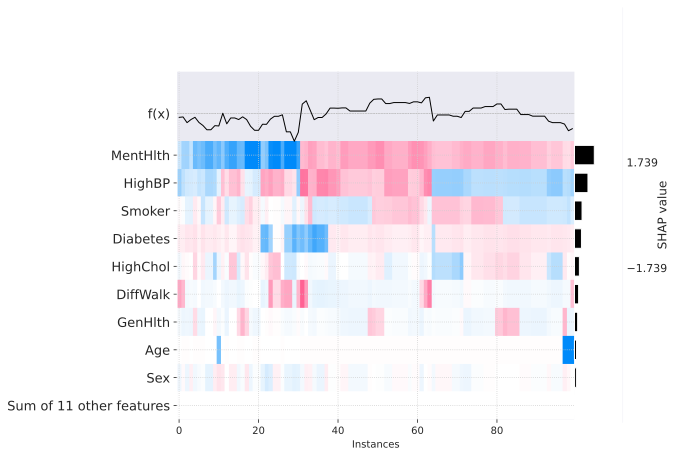

In [ ]:
shap.initjs()
n = 100
shap.plots.heatmap(explainer(X_test.iloc[:n]))